# <h1 align=center> DCGAN ile Keras Kullanarak Sentetik Görüntü Oluşturulması</h1>

---
<h3 align=center>(Deep Convolutional Generative Adversarial

---

![GAN Fake Face](https://i.pinimg.com/originals/f8/ac/28/f8ac28ae8df799128f2609d79011b045.gif) </h3>

Sentetik veri üretmek yapay zeka konusundaki çalışmalar listesinde ilk sıralarda yerini alıyor. Bir veriye benzer veri üretmenin yanında görsel, işitsel ve yazılı sanat eserleri de üretebiliyor. Gerçeğinden ayırt edemeyeceğiniz insan yüzleri de üretebiliyorsunuz. Bir sanatçının stilini de taklit edebiliyorsunuz. Medikal alanda size gerekli olacak verinin mevcutlardan faydalanarak çoğaltılmasını da sağlamak amacıyla kullanılabiliyor. Tüm bunlar örüntülerin başarılı şekilde çıkarılmasıyla mümkün oluyor. 

---

Derin üretici ağlar GAN'lardan ibaret değil! Boltzmann makinesi yaklaşımları (Boltzmann Machines), Derin inanç ağları (Deep Belif Networks), Evrişimsel Boltzmann yaklaşımları (Convolutional Boltzmann Machines), Yönlü (Directed Generative Nets) ve Değişimsel Otokodlayıcılar (Variational Autoencoders) gibi farklı yaklaşımlar GAN'lar dan önce ve hala kullanılıyor. İlginizi çekerse bu anahtar kelimeleri de araştırabilirsiniz.[*](https://www.deeplearningbook.org/contents/generative_models.html)

*  [*Yeni ve farklı GAN yaklaşımları da var. Yaklaşık 200 GAN yaklaşımını listeyen bu repoyu inceleyebilirsiniz.*](https://github.com/hindupuravinash/the-gan-zoo) 

---



### İşlemleri GPU üzerinde gerçekleştirilmesi
Google Colab'da çalışırken eğitimleri GPU üzerinde veye TPU üzerinde eğitmek zaman bakımından fark yaratıcı olacaktır.

Aşağıdaki kaynaklar ve onlar içindeki diğer kaynaklardan bu ücretsiz bulut servislerinin nasıl kullanılabileceğini öğrenebilirsiniz.

[Google Colab'da GPU'yu nasıl kullanabilirim!](https://www.youtube.com/watch?v=bT-T1i_Rpy8)
[Google Colab'da TPU'yu nasıl kullanabilirim!](https://medium.com/@ayyucekizrak/ad%C4%B1m-ad%C4%B1m-google-colab-%C3%BCcretsiz-tpu-kullan%C4%B1m%C4%B1-621dc6e5487d)
[TPU ile Yapay Sinir Ağlarınızı Çok Daha Hızlı Eğitin - Google I/O 2019 GoogleCodeLabs](https://github.com/yapay-ogrenme/googlecodelabs/wiki)

*GPU: Graphic Processing Unit (Grafik işlem birimi)*

*TPU: Tensor Processing Unit (Tensor işlem birimi)* 

In [1]:
#GPU kullanmak için kimlik doğrulama işlemi
from google.colab import drive
drive.mount('/gdrive')
#%cd /gdrive

Mounted at /gdrive


In [4]:
!ls "/gdrive/My Drive/Calisma_ortami"

 Datasets
 DCGAN_ile_Keras_Kullanarak_Sentetik_Goruntu__Olusturulmasi.ipynb
'Derin Sinir Aglari.ipynb'
 Duygu_Tanima
 Egitilmis_Modeller
 Evrisimli_Sinir_Aglari.ipynb
'RNN (Recurrent Neural Network).ipynb'
 Uretici_Modeller.ipynb
'YSA Temelleri ve Düzenlilestirme Yaklasimlari.ipynb'


In [5]:
import os
os.chdir("/gdrive/My Drive/Calisma_ortami")

In [8]:
#Kullanacağınız donanım özelliklerini bu kod parçasını çalıştırarak görebilirsiniz.
import tensorflow as tf
tf.test.gpu_device_name()
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6403339312326897751
 xla_global_id: -1]

### Üretici Çekişmeli Ağlar (GAN)

2014 yılından bu yana heyecan verici yapay zeka konularından olan değişimsel otokodlayıcılar (Variatinoal autoencoders - VAEs).  ve üretici çekişmeli ağlar (Generative adverserial networks - GANs) ile görüntülerdeki saklı uzayının örneklenmesiyle var olan görseli değiştirme ya da yenisini üretmek mümkün hale geliyor. Ian Goodfellow ile derin öğrenme dünyasını sarsan GAN yaklaşımı istatistiksel anlamda gerçeğinden ayırt edilemeyen sentetik verilerin üretilmesinin önünü açıyor. Çalışma yapısında başlangıçta kötü bir taklitçi gibi düşünülebilir. Taklit yeteneği giderek gelişir ve gerçeğinden ayırt edilemeyen fakat aynısı olmayan yeni çıktılar üretilmektedir. 

[GAN için temel kaynak](https://arxiv.org/pdf/1406.2661.pdf)

Bu çalışma dosyasında DCGAN yani evrişimli bir GAN tipini ele alarak konunun mantığını uygulamalı olarak göstermeye çalışıyorum. Aşağıdaki şekil temel bir GAN yapısını ifade ediyor.

![GAN](https://i.hizliresim.com/00TSUo.png)

[Şekil kaynağı](https://www.tensorflow.org/tutorials/generative/images/gan1.png)


---



## 1.ADIM: Gereken kütüphanelerin yüklenmesi

In [ ]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
print('Tensorflow version:', tf.__version__)

In [10]:
def show(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

## 2.ADIM: Verilerin yüklenmesi ve önişlemlerin gerçekleştirilmesi

Bu çalışmada [Fashion MNIST](https://www.kaggle.com/zalando-research/fashionmnist) veri kümesini kullanacağız ve bu veri kümesinde çok çeşitli ayakkabı, bot, sandalet, tişört, kaban, bandana vb. tekstil ürününden etiketli örnekler yer almaktadır.

In [ ]:
#Fashion MNIST veri kümesinin keras yoluyla indiriyoruz. 
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

In [ ]:
# Veri kümesinden 10x10 piksel büyüklüklü 25 tane örnek ekrana yazdırıp neye benzediğine bakalım.
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
plt.show()

## 3.ADIM: Eğtim verileri ve gruplarının oluşturulması

In [13]:
batch_size = 32
# Bu veri kümesi, bir arabelleği buffer_size elemanları ile doldurur,
#ardından seçilen elemanları yeni elemanlarla değiştirerek rastgele örnekler.
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
# Bu veri kümesinin ardışık öğelerini toplu olarak birleştirir.
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

## 4.ADIM: DCGAN için üretici (generator) ağının oluşturulması

Denklemde D ayırt edici (ayırıcı), G ise üretici olarak tanımlanmakta ve aralarındaki çekişme ifade ediliyor. Aslında bu temel bir *oyun teorisi* yaklaşımıdır.

Burada ters evrişim işlemi yaparak ve rastgele gürültüden başlayan bir görseller yapısı elde ediyoruz. Giderek bu üreticiyi gerçek görsellere benzer üretimler yapmasını aşağıdaki denklem yoluyla sağlıyoruz. 

![GAN Denklemi](https://i.hizliresim.com/IknKWJ.png)

Bu denklem aşağıdaki görseldeki yapıyı temsil ediyor:

![GAN Anlama](https://i.hizliresim.com/mYldwo.gif)

Kaynak: [Play with Generative Adversarial Networks (GANs) in your browser!](https://poloclub.github.io/ganlab/)

---

GAN modellerde genellikler aktivasyon fonksiyonu olarak **SELU** ve **TANH** ara katmanlarda kullanılır. Çıkış katmanlarında ise **SIGMOID** ya da **SOFTMAX** tercih edilir. 

Aktivasyon fonksiyonlarıyla ilgili uygulamalı, sözlü ve yazılı anlatımı için **[buraya](https://medium.com/@ayyucekizrak/derin-%C3%B6%C4%9Frenme-i%C3%A7in-aktivasyon-fonksiyonlar%C4%B1n%C4%B1n-kar%C5%9F%C4%B1la%C5%9Ft%C4%B1r%C4%B1lmas%C4%B1-cee17fd1d9cd)** göz atabilirsiniz.

---

DCGAN ise Evrişim ve Ters Evrişimden oluşan iki ağdan oluşuyor. Üretici ve Ayırcı ağlarının evrişimli olmasından dolayı adına *Derin Evrişimli Üretici Çekişmeli Ağlar* deniyor.

[DCGAN için temel kaynak](https://arxiv.org/pdf/1511.06434.pdf)

![DCGAN](https://i.hizliresim.com/XnsRnK.jpg)

[Şekil kaynağı](https://arxiv.org/pdf/1511.06434.pdf)

---

Üretici ve ayırıcı ağların derin evrişimli ağ olduğu bir GAN Üreticide resimlerin boyut büyütme işlemleri `Conv2DTranspose` katmanı kullanılarak yapılıyor. 

Üretici (generator) ağ, şekilden de görüldüğü gibi rastgele Gauss gürültüsü olan bir tensordur. Biz `7 * 7* 128` boyutlu bir girişle başlıyoruz. Bu test iki boyutlu evrişim katmanları ile her katmanda kanal sayısını azaltıp genişlik ve yüksekliği artırarak **sentetik** bir görüntü elde etmeye çalışıyoruz. Üretici ağ ayırıcı ağı yanıltmak için eğitilir ve eğitim boyunca yitimi minimize ederek daha gerçekçi görseller üretir. 

In [14]:
# ÜRETİCİ KATMANINDAKİ EVRİŞİMLİ SİNİR AĞI
num_features = 100 # öznitelik sayısı

# giriş değerini verdiğimiz features sayısına göre başlatıyoruz
# Conv2DTranpose versiyonunu kullanıyoruz. 
generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[num_features]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, (5,5), (2,2), padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, (5,5), (2,2), padding="same", activation="tanh"),
])

*   GAN modellerken saklı uzay örnekler seçerken düzgün dağılım yerine *normal dağılım* (Gauss Dağılımı) kullanılıyor.
*   Stokastiklik dayanıklılığı artırır. GAN eğitim sonuçları dinamik bir dengede olduğundan, GAN'lar her yönden çıkmaza girmeye müsaittir. Rastgelelik eğitim esnasında bunun olmasını engellemeye yardımcı olur. 

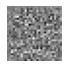

In [15]:
noise = tf.random.normal(shape=[1, num_features])
generated_images = generator(noise, training=False)
show(generated_images, 1)

## 5.ADIM: DCGAN için ayırıcı (discriminator) ağının oluşturulması

Ayırıcı ağ, girdi olarak bir görsel alır -bu sentetik veya gerçek olabilir- ve görselin eğitim veri setinden mi geldiğini yoksa üretici ağın mı örettiğini tahmin eder. Modelin bu kısmı bildiğimiz bir evrişimli sinir ağından meydana geliyor ve bir sınıflayıcı gibi çalışıyor. Görüntüden başlayıp tüm bağlantı katmanlarına doğru ilerleyen iki evrişim iki aktivasyon fonksiyonu katmanı bulunuyor. Ayırt edici bu modelde aktivasyon fonksiyonu olarak **LeakyReLU** veya **ReLU** tercih ediliyor.

In [16]:
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, (5,5), (2,2), padding="same", input_shape=[28, 28, 1]),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(128, (5,5), (2,2), padding="same"),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])

In [17]:
# Üretilen görsel için ayırt edici %50nin altında bir değer üretti ilk adım için 
decision = discriminator(generated_images)
print(decision)

tf.Tensor([[0.50200224]], shape=(1, 1), dtype=float32)


## 6.ADIM: Derin Evrişimli Üretici Çekişmeli Ağınızı (DCGAN) Derlenmesi

Artık modeliniz saklı uzayın noktalarını "gerçek" veya "sahte" sınıflandırması yapabilecek. Üretici ağın ağırlıkları ile ayırıcı ağ güncellenecektir. Bu yüzden ayırıcı ağı eğitilmeyecek şekilde ayarlamamız gerekir. Bu bahsettiğim aşağıdaki `discriminator.trainable=False` ile gerçekleştiriliyor. 

* Eğer ayırıcıyı eğitilebilir olarak ayarlarsak yani eğitim sırasında kendi ağırlıklarını güncellerse, her zaman "gerçek" demek üzere eğitilmiş olacak ve biz sentetik veri üretmeye çalışıyorsak bu istemediğimiz bir şeydir.

Yitim yani loss fonksiyonumuzu ve optimizasyon algoritmamızı tercih ediyoruz. Üretici ve ayırt edici modelleri denge sağlaması üzere çekişmeye hazırlıyoruz :) 

*  Eğer eğitim sırasında çekişmeli ağın yitim değeri çok yükselirse, ayırıcı ağın kaybının sıfıra yaklaştığını göreceksiniz. Bu üretici ağa baskın çıktığı anlamına gelir ve üretici istediğimiz gibi sentetik veri üretme konusunda başarılı değil demektir. Bunun önüne geçmek için ayırıcı modelin öğrenme oranını düşürmeyi deneyebilirsiniz.


In [18]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan = keras.models.Sequential([generator, discriminator])
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

## 7.ADIM: Eğitim işlemlerini görseleştirilmesi
Bu adımda progress adımlarını tanımlıyoruz. Eğitim sırasında her bir epoch da üretici modelden elde ettiğimiz sonuçları ekrana yazdıralım ve her ekrana yazdırdığımız görüntüyü kaydedelim istiyoruz. Çünkü en sonda eğitim süresince epochların sonuçlarındaki iyileşmeyi görselleştirebiliriz.



In [19]:
from IPython import display
from tqdm import tqdm
seed = tf.random.normal(shape=[batch_size, 100])

In [20]:
from tqdm import tqdm
def train_dcgan(gan, dataset, batch_size, num_features, epochs=5):
    generator, discriminator = gan.layers
    for epoch in tqdm(range(epochs)):
        print("Epoch {}/{}".format(epoch + 1, epochs))
        for X_batch in dataset:
            noise = tf.random.normal(shape=[batch_size, num_features])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            noise = tf.random.normal(shape=[batch_size, num_features])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
            # Üretilen görüntüleri ekrana yazdırıp doyaya kaydedelim
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [22]:
## Kaynak: https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
def generate_and_save_images(model, epoch, test_input):
  # 'Eğitim' False seçeneğine ayarlandı.
  # Böylece tüm katmanlar çıkarım modunda (batchnorm) çalışır.
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(10,10))

  for i in range(25):
      plt.subplot(5, 5, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## 8.ADIM: DCGAN'ın eğitilmesi

Bu adımda tanımladığımız gan, dataset, batch_size, num_features ve epoch değerlerine göre eğitim işlemini gerçekleştirip sonuçları ekrana yazdırıyoruz.

In [23]:
# Eğitim için yeniden boyutlandırmanın yapılması
x_train_dcgan = x_train.reshape(-1, 28, 28, 1) * 2. - 1.

In [24]:
#Batch size boyutunun ve shuffle özelliklerinin belirlenmesi
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

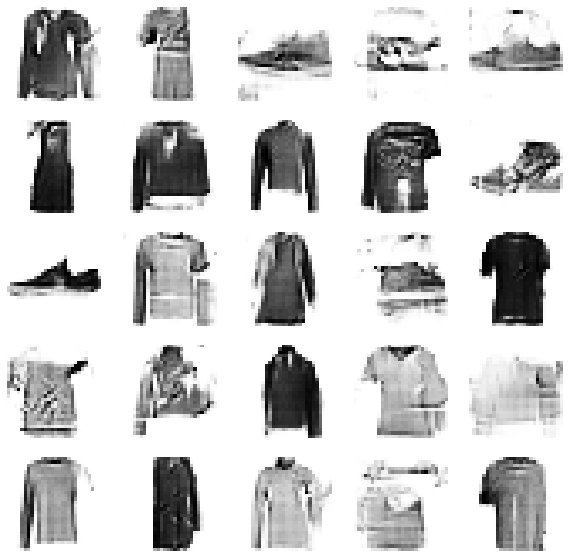

CPU times: user 2h 26min 24s, sys: 5min 11s, total: 2h 31min 36s
Wall time: 1h 23min 44s


In [25]:
# Eğitim gan modeli, tanımlanan dataset için belirlenen batch_size boyutu ve öznitelik sayısı ile
# 10 epoch olarak gerçekleşecek, siz de epoch sayısını değiştirerek modelin gelişimini gözlemlereyebilrisiniz.
%%time 
train_dcgan(gan, dataset, batch_size, num_features, epochs=10)

## 9.ADIM: DCGAN ile sentetik görüntülerin oluşturulması

Bu adımda en başta tanımladığımız `show` fonksiyonundan faydalanarak üretici ağın ürettiği sonuçları görselleştiriyoruz.

Her epoch için elde ettiğimiz sonuçları .png formatında kaydettikten sonra bunu .gif formatına dönüştürüp ekrana yazdırıyoruz ve dosyaya kaydediyoruz. 

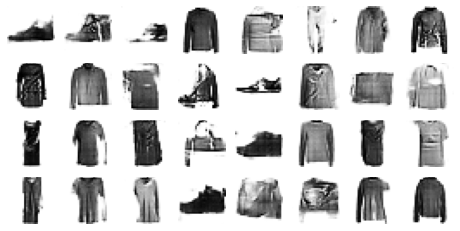

In [26]:
noise = tf.random.normal(shape=[batch_size, num_features])
generated_images = generator(noise)
show(generated_images, 8)

In [27]:
# Sonuçları GIF olarak göstermek için bu kısmı çalıştırın.
## Kaynak: https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
import imageio
import glob

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

from IPython.display import Image
Image(open(anim_file,'rb').read())

Output hidden; open in https://colab.research.google.com to view.

### SONUÇ

Derin evrişimli üretici çekişmeli ağları kullanarak (DCGAN) görüntü üzerinde çalışan çoğu kişinin bildiği Fashion Mnıst veri kümesinden sentetik veri üretimi gerçekleştirdik. Benzer nitelikte daha fazla veriye ihtiyacınız olan durumlarda veri toplamak zaman alan ve maliyetli olması dolayısıyla böyle bir yolla veri kümenizi genişletebilirsiniz. DCGAN sonuçlarınızı iyileştirmek için üretici ve ayırıcı ağlarda uygun şekilde katman artırabilirsiniz (bu çalışma için modeller çok derin oluşturulmadı). 


---

### KAYNAKLAR:

*   [Coursera Course: Generate Synthetic Images with DCGANs in Keras](https://www.coursera.org/projects/generative-adversarial-networks-keras)
*   [Generative Adversarial Nets](https://arxiv.org/pdf/1406.2661.pdf)
*   [Unsupervised Representation Learning with Deep Convolutional Generative Adverserial Networks](https://arxiv.org/pdf/1406.2661.pdf)
*   [Unsupervised Representation Learning with Deep Convolutional Generative Adverserial Networks](https://arxiv.org/pdf/1406.2661.pdf)
*   [Play with Generative Adversarial Networks (GANs) in your browser!](https://poloclub.github.io/ganlab/)
*   [Python ile Derin Öğrenme - François Chollet](https://www.buzdagikitabevi.com/derin-ogrenme-seti)



